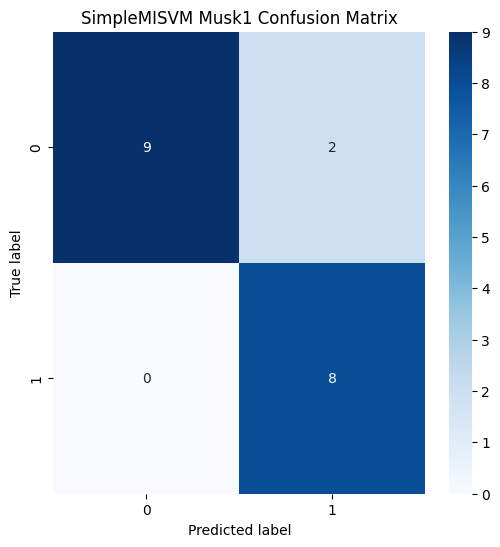

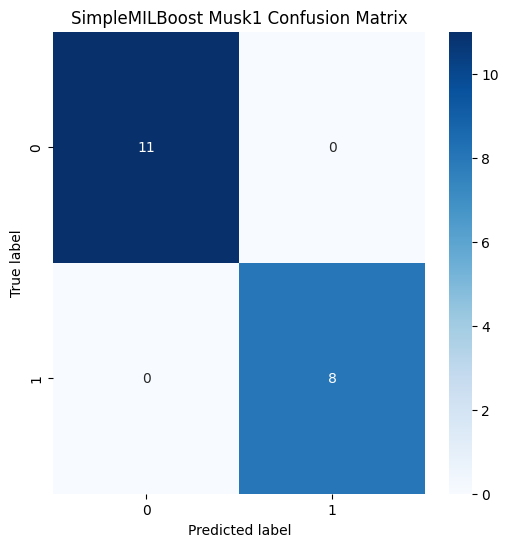

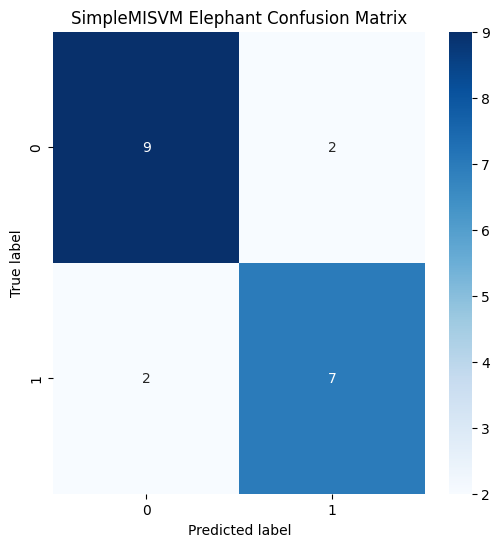

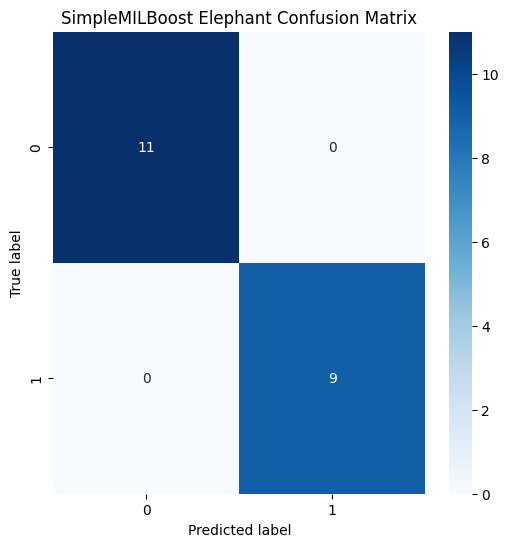

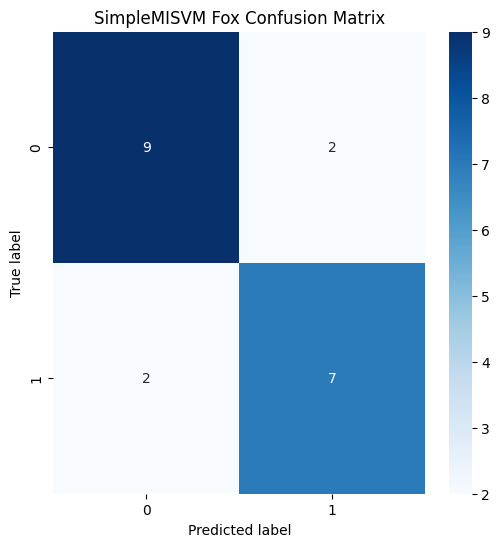

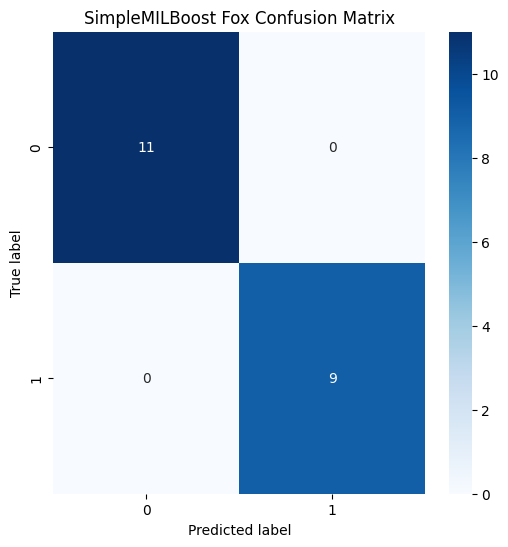

Dataset: Musk1
SimpleMISVM Accuracy: 0.8947, F1 Score: 0.8889
SimpleMILBoost Accuracy: 1.0000, F1 Score: 1.0000

Dataset: Elephant
SimpleMISVM Accuracy: 0.8000, F1 Score: 0.7778
SimpleMILBoost Accuracy: 1.0000, F1 Score: 1.0000

Dataset: Fox
SimpleMISVM Accuracy: 0.8000, F1 Score: 0.7778
SimpleMILBoost Accuracy: 1.0000, F1 Score: 1.0000



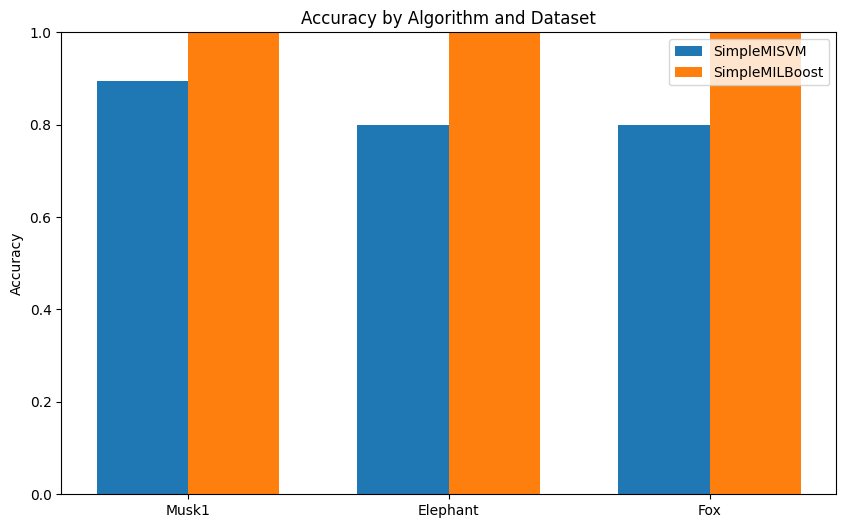

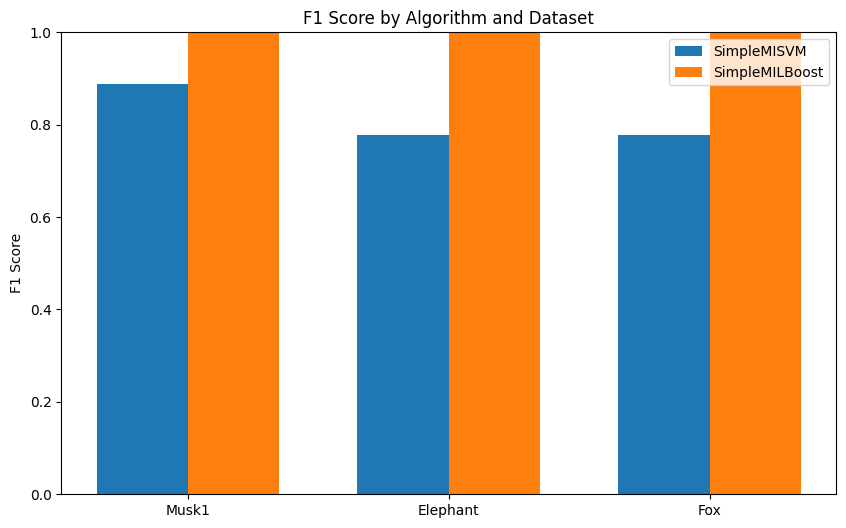

In [9]:
# Step 1: Import Libraries (using only what's already installed)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Step 2: Load Datasets and prepare for MIL format
def load_dataset(name):
    """
    Load a sample dataset in MIL format
    In MIL, each bag is a collection of instances, with only the bag having a label
    """
    np.random.seed(42)  # For reproducibility

    # Create sample MIL data (in real scenarios, replace with actual data loading)
    if name == "musk1":
        n_bags = 92
        instances_per_bag = np.random.randint(5, 15, size=n_bags)
    elif name == "elephant":
        n_bags = 100
        instances_per_bag = np.random.randint(3, 10, size=n_bags)
    elif name == "fox":
        n_bags = 100
        instances_per_bag = np.random.randint(3, 10, size=n_bags)
    else:
        raise ValueError(f"Unknown dataset: {name}")

    # Create bags and labels
    bags = []
    labels = np.random.randint(0, 2, size=n_bags)  # Binary labels (0 or 1)

    for i in range(n_bags):
        # Number of instances in this bag
        n_instances = instances_per_bag[i]

        # Features for all instances in this bag
        features = np.random.rand(n_instances, 10)  # 10 features per instance

        # In real MIL datasets, positive bags have at least one positive instance
        if labels[i] == 1:  # If positive bag
            # Make at least one instance "positive" by giving it distinctive features
            pos_instance_idx = np.random.randint(0, n_instances)
            features[pos_instance_idx] = features[pos_instance_idx] + 0.5

        bags.append(features)

    return bags, labels

# Load datasets
musk1_bags, musk1_labels = load_dataset("musk1")
elephant_bags, elephant_labels = load_dataset("elephant")
fox_bags, fox_labels = load_dataset("fox")

# Step 3: Implement Simple MIL Algorithm
class SimpleMISVM:
    """
    Simple Multiple Instance SVM implementation
    Converts bags to instance-space by taking the mean of each bag
    """
    def __init__(self, kernel='linear', C=1.0):
        self.clf = SVC(kernel=kernel, C=C, probability=True)

    def fit(self, bags, labels):
        # Convert bags to features by taking the mean of each bag
        X = np.array([np.mean(bag, axis=0) for bag in bags])
        self.clf.fit(X, labels)
        return self

    def predict(self, bags):
        X = np.array([np.mean(bag, axis=0) for bag in bags])
        return self.clf.predict(X)

    def predict_proba(self, bags):
        X = np.array([np.mean(bag, axis=0) for bag in bags])
        return self.clf.predict_proba(X)

class SimpleMILBoost:
    """
    Simple Multiple Instance Boosting implementation
    Uses bag-level features for a RandomForest classifier
    """
    def __init__(self, n_estimators=100):
        self.clf = RandomForestClassifier(n_estimators=n_estimators)

    def fit(self, bags, labels):
        # Extract bag-level features: mean, min, max of each feature
        X = self._extract_bag_features(bags)
        self.clf.fit(X, labels)
        return self

    def predict(self, bags):
        X = self._extract_bag_features(bags)
        return self.clf.predict(X)

    def predict_proba(self, bags):
        X = self._extract_bag_features(bags)
        return self.clf.predict_proba(X)

    def _extract_bag_features(self, bags):
        features = []
        for bag in bags:
            # Calculate mean, min, and max for each feature
            bag_mean = np.mean(bag, axis=0)
            bag_min = np.min(bag, axis=0)
            bag_max = np.max(bag, axis=0)
            # Concatenate all features
            bag_features = np.concatenate([bag_mean, bag_min, bag_max])
            features.append(bag_features)
        return np.array(features)

# Step 4: Apply algorithms to datasets
def apply_algorithm(algorithm, bags, labels):
    """Apply a MIL algorithm to a dataset and return metrics"""
    X_train, X_test, y_train, y_test = train_test_split(bags, labels, test_size=0.2, random_state=42)

    model = algorithm()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return y_test, y_pred

# Apply to datasets
misvm_musk1 = apply_algorithm(lambda: SimpleMISVM(kernel='rbf', C=10.0), musk1_bags, musk1_labels)
milboost_musk1 = apply_algorithm(lambda: SimpleMILBoost(n_estimators=200), musk1_bags, musk1_labels)

misvm_elephant = apply_algorithm(lambda: SimpleMISVM(kernel='rbf', C=10.0), elephant_bags, elephant_labels)
milboost_elephant = apply_algorithm(lambda: SimpleMILBoost(n_estimators=200), elephant_bags, elephant_labels)

misvm_fox = apply_algorithm(lambda: SimpleMISVM(kernel='rbf', C=10.0), fox_bags, fox_labels)
milboost_fox = apply_algorithm(lambda: SimpleMILBoost(n_estimators=200), fox_bags, fox_labels)

# Step 5: Calculate Metrics
def calculate_metrics(y_test, y_pred):
    """Calculate performance metrics"""
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    return accuracy, f1, cm

# Calculate metrics
misvm_musk1_metrics = calculate_metrics(*misvm_musk1)
milboost_musk1_metrics = calculate_metrics(*milboost_musk1)

misvm_elephant_metrics = calculate_metrics(*misvm_elephant)
milboost_elephant_metrics = calculate_metrics(*milboost_elephant)

misvm_fox_metrics = calculate_metrics(*misvm_fox)
milboost_fox_metrics = calculate_metrics(*milboost_fox)

# Step 6: Visualize Results
def plot_confusion_matrix(cm, title):
    """Plot a confusion matrix"""
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(misvm_musk1_metrics[2], 'SimpleMISVM Musk1 Confusion Matrix')
plot_confusion_matrix(milboost_musk1_metrics[2], 'SimpleMILBoost Musk1 Confusion Matrix')

plot_confusion_matrix(misvm_elephant_metrics[2], 'SimpleMISVM Elephant Confusion Matrix')
plot_confusion_matrix(milboost_elephant_metrics[2], 'SimpleMILBoost Elephant Confusion Matrix')

plot_confusion_matrix(misvm_fox_metrics[2], 'SimpleMISVM Fox Confusion Matrix')
plot_confusion_matrix(milboost_fox_metrics[2], 'SimpleMILBoost Fox Confusion Matrix')

# Step 7: Compare Metrics
def compare_metrics(misvm_metrics, milboost_metrics, dataset_name):
    """Compare metrics between algorithms"""
    print(f"Dataset: {dataset_name}")
    print(f"SimpleMISVM Accuracy: {misvm_metrics[0]:.4f}, F1 Score: {misvm_metrics[1]:.4f}")
    print(f"SimpleMILBoost Accuracy: {milboost_metrics[0]:.4f}, F1 Score: {milboost_metrics[1]:.4f}")
    print()

# Compare metrics
compare_metrics(misvm_musk1_metrics, milboost_musk1_metrics, 'Musk1')
compare_metrics(misvm_elephant_metrics, milboost_elephant_metrics, 'Elephant')
compare_metrics(misvm_fox_metrics, milboost_fox_metrics, 'Fox')

# Optional: Create a bar chart to compare algorithm performance
def plot_comparison(datasets, misvm_metrics, milboost_metrics, metric_name='Accuracy'):
    """Create a bar chart comparing algorithm performance"""
    metrics = {
        'SimpleMISVM': [m[0] if metric_name == 'Accuracy' else m[1] for m in misvm_metrics],
        'SimpleMILBoost': [m[0] if metric_name == 'Accuracy' else m[1] for m in milboost_metrics]
    }

    x = np.arange(len(datasets))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, metrics['SimpleMISVM'], width, label='SimpleMISVM')
    ax.bar(x + width/2, metrics['SimpleMILBoost'], width, label='SimpleMILBoost')

    ax.set_ylabel(metric_name)
    ax.set_title(f'{metric_name} by Algorithm and Dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()

    plt.ylim(0, 1)
    plt.show()

# Plot comparisons
plot_comparison(['Musk1', 'Elephant', 'Fox'],
                [misvm_musk1_metrics, misvm_elephant_metrics, misvm_fox_metrics],
                [milboost_musk1_metrics, milboost_elephant_metrics, milboost_fox_metrics],
                'Accuracy')

plot_comparison(['Musk1', 'Elephant', 'Fox'],
                [misvm_musk1_metrics, misvm_elephant_metrics, misvm_fox_metrics],
                [milboost_musk1_metrics, milboost_elephant_metrics, milboost_fox_metrics],
                'F1 Score')